In [21]:

import seaborn as sns
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.model_selection import train_test_split
from hmmlearn import hmm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, recall_score, precision_score, f1_score, roc_auc_score, roc_curve
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
import joblib



### 1. Задача

Необходимо предложить обоснованный прогноз отказа моторов и описать варианты использования предложенного решения на практике.

Описание данных (архив для загрузки в аттач ):
    id -- идентификатор мотора
    cycle -- цикл работы
    p00-p20 -- показания датчиков считываемые в процессе работы
    s0, s1 -- настройки изменяемые в конце каждого цикла

Считаем, что максимальный цикл мотора в данных - это последний цикл перед поломкой.
Базовый вариант – прогноз поломки на следующем цикле.

### 2. Загрузка данных и EDA

In [2]:
df = pd.read_csv('data/data.csv')
df

,id,cycle,p00,p01,p02,p03,p04,p05,p06,p07,...,p13,p14,p15,p16,p17,p18,p19,p20,s1,s2
0,1,1,518.67,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,...,23.4190,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,-0.0007,-0.0004
1,1,2,518.67,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,...,23.4236,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,0.0019,-0.0003
2,1,3,518.67,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,...,23.3442,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,-0.0043,0.0003
3,1,4,518.67,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,...,23.3739,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,0.0007,0.0000
4,1,5,518.67,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,...,23.4044,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,-0.0019,-0.0002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16133,80,181,518.67,1.3,48.17,520.44,2388.17,8218.63,8.5194,0.03,...,23.1678,1604.26,1428.92,14.62,21.61,552.24,2388.20,9145.62,0.0042,0.0002
16134,80,182,518.67,1.3,48.41,520.06,2388.12,8221.91,8.5493,0.03,...,23.0142,1598.32,1426.31,14.62,21.61,551.60,2388.16,9160.23,-0.0014,0.0004
16135,80,183,518.67,1.3,48.04,519.67,2388.21,8217.46,8.5106,0.03,...,22.9337,1603.37,1434.30,14.62,21.61,551.78,2388.12,9152.84,0.0018,0.0000
16136,80,184,518.67,1.3,48.04,519.72,2388.20,8228.65,8.4983,0.03,...,22.9971,1603.01,1430.23,14.62,21.61,551.78,2388.17,9164.10,-0.0024,0.0002


In [3]:
df.describe()

,id,cycle,p00,p01,p02,p03,p04,p05,p06,p07,...,p13,p14,p15,p16,p17,p18,p19,p20,s1,s2
count,16138.000000,16138.000000,16138.00,1.613800e+04,16138.000000,16138.000000,16138.000000,16138.000000,16138.000000,1.613800e+04,...,16138.000000,16138.000000,16138.000000,1.613800e+04,16138.000000,16138.000000,16138.000000,16138.000000,16138.000000,1.613800e+04
mean,40.707894,105.548147,518.67,1.300000e+00,47.544263,521.405420,2388.096737,8143.933458,8.442581,3.000000e-02,...,23.288552,1590.582096,1409.033729,1.462000e+01,21.609795,553.359776,2388.097368,9065.461291,0.000010,6.196555e-08
std,23.395354,65.915295,0.00,2.220515e-16,0.267422,0.738252,0.072604,19.731349,0.037520,1.387822e-17,...,0.108606,6.129960,8.977073,3.552824e-15,0.001417,0.887947,0.071608,22.781362,0.002188,2.939096e-04
min,1.000000,1.000000,518.67,1.300000e+00,46.860000,518.690000,2387.880000,8099.940000,8.324900,3.000000e-02,...,22.907100,1571.040000,1382.250000,1.462000e+01,21.600000,549.850000,2387.900000,9021.730000,-0.008600,-6.000000e-04
25%,20.000000,51.000000,518.67,1.300000e+00,47.350000,520.940000,2388.040000,8132.830000,8.415300,3.000000e-02,...,23.220600,1586.330000,1402.500000,1.462000e+01,21.610000,552.800000,2388.050000,9052.820000,-0.001400,-3.000000e-04
50%,42.000000,101.000000,518.67,1.300000e+00,47.520000,521.460000,2388.090000,8140.750000,8.439800,3.000000e-02,...,23.296300,1590.190000,1408.220000,1.462000e+01,21.610000,553.430000,2388.090000,9060.750000,0.000000,0.000000e+00
75%,61.000000,153.000000,518.67,1.300000e+00,47.710000,521.940000,2388.140000,8148.817500,8.466000,3.000000e-02,...,23.365600,1594.450000,1414.650000,1.462000e+01,21.610000,554.000000,2388.140000,9069.940000,0.001500,3.000000e-04
max,80.000000,362.000000,518.67,1.300000e+00,48.530000,523.380000,2388.560000,8293.720000,8.584800,3.000000e-02,...,23.612700,1614.930000,1441.490000,1.462000e+01,21.610000,556.060000,2388.560000,9244.590000,0.008700,6.000000e-04


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16138 entries, 0 to 16137
Data columns (total 25 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      16138 non-null  int64  
 1   cycle   16138 non-null  int64  
 2   p00     16138 non-null  float64
 3   p01     16138 non-null  float64
 4   p02     16138 non-null  float64
 5   p03     16138 non-null  float64
 6   p04     16138 non-null  float64
 7   p05     16138 non-null  float64
 8   p06     16138 non-null  float64
 9   p07     16138 non-null  float64
 10  p08     16138 non-null  int64  
 11  p09     16138 non-null  int64  
 12  p10     16138 non-null  int64  
 13  p11     16138 non-null  float64
 14  p12     16138 non-null  float64
 15  p13     16138 non-null  float64
 16  p14     16138 non-null  float64
 17  p15     16138 non-null  float64
 18  p16     16138 non-null  float64
 19  p17     16138 non-null  float64
 20  p18     16138 non-null  float64
 21  p19     16138 non-null  float64
 22

###### пропусков нет, значит никак обрабатывать не надо. Есть константные величины, их удаляем, т.к. не влияют на результат, также удалим s1, s2 - это гиперпараметры системы, т.е. внешние задаваемые параметры, а мы строим модель ориентируясь на показатели самой системы

In [5]:
# Удаление указанных колонок
columns_to_drop = ['p00', 'p01', 'p07', 'p09', 'p10', 'p16', 'p17', 'p20', 's1', 's2']
df.drop(columns=columns_to_drop, inplace=True)

###### построим графики величин для случайного двигателя (взял id = 2, как пример)

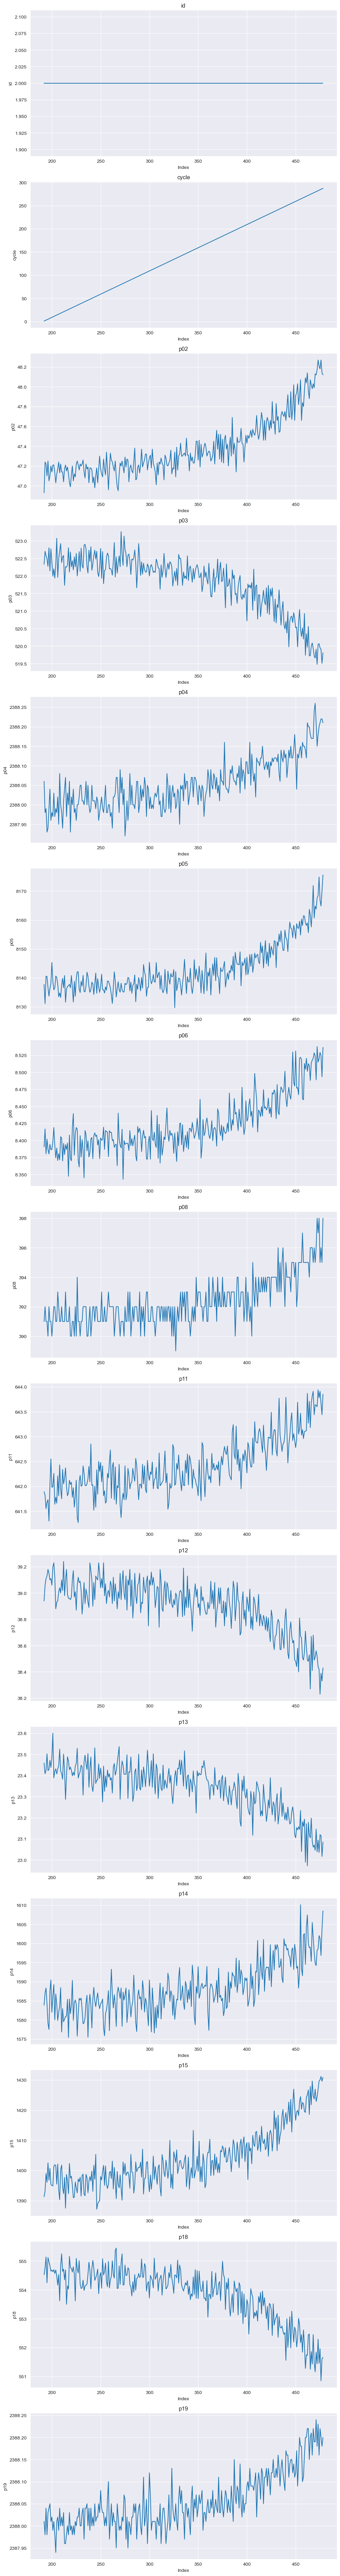

In [6]:
# Функция для построения графиков
def plot_columns(dataframe):
    num_columns = len(dataframe.columns)
    fig, axes = plt.subplots(num_columns, 1, figsize=(10, 5 * num_columns))

    for i, column in enumerate(dataframe.columns):
        ax = axes[i] if num_columns > 1 else axes
        dataframe[column].plot(ax=ax, title=column)
        ax.set_xlabel("Index")
        ax.set_ylabel(column)

    plt.tight_layout()
    plt.show()

# Построение графиков
plot_columns(df[df['id']==2])

###### графики выглядят скореллированными, посмотрим матрицу корреляций

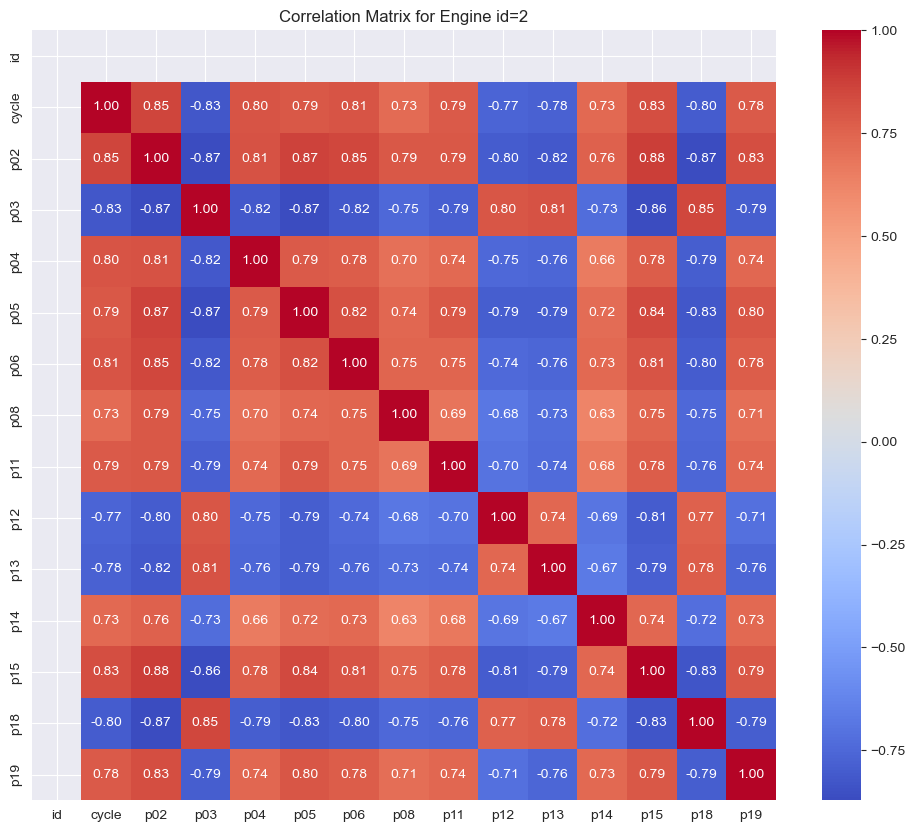

In [7]:
# Выбор данных для одного двигателя с id=2
one_motor_df = df[df['id'] == 2].copy()

# Построение матрицы корреляции
correlation_matrix = one_motor_df.corr()

# Визуализация матрицы корреляции
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix for Engine id=2')
plt.show()

###### Да, мы видим высокую корреляюцию между параметрами, значит в дальнейшем, при необходимости оптимизации модели, мы можем использовать только часть признаков.
Следующая мысль - возможно точки отказа, это какие-то особые точки, аномалии? При помощи метода T-SNE сделаем проекцию по всем моторам 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


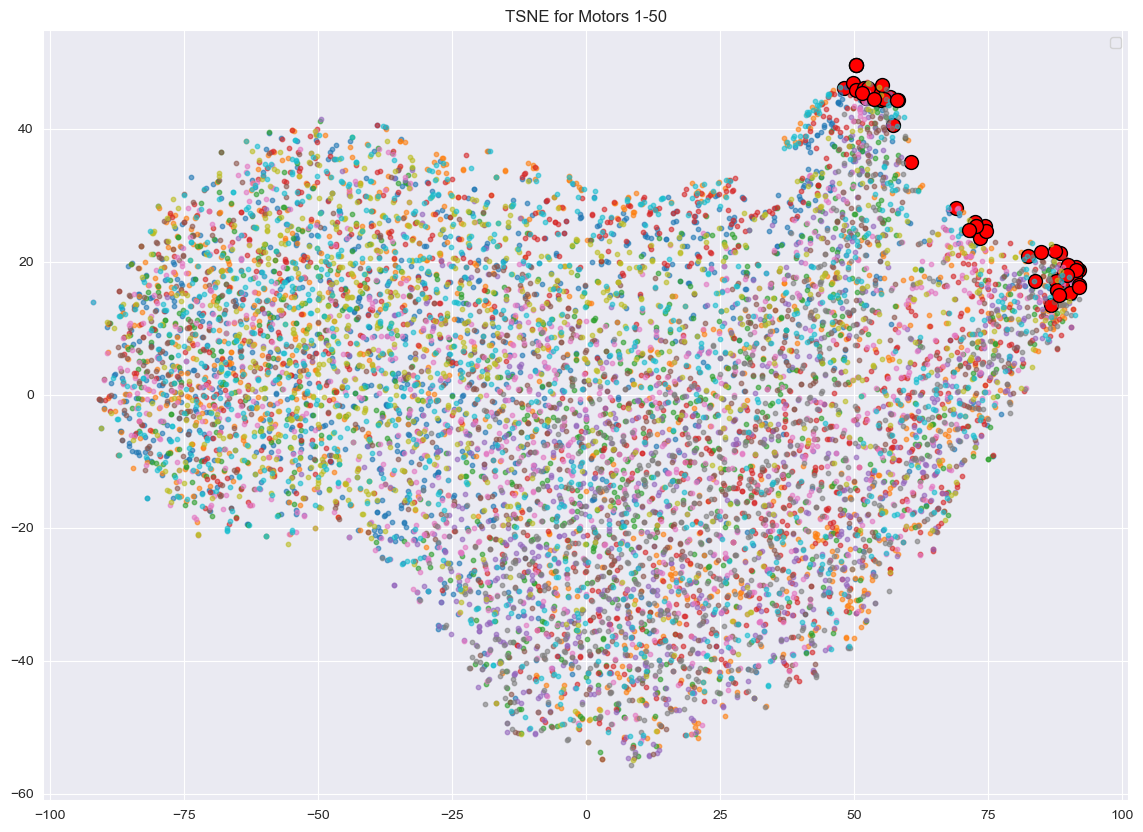

In [11]:
# Создание меток для выхода из строя
df['failure'] = df.groupby('id')['cycle'].transform(lambda x: x == x.max()).astype(int)

# Задаем количество двигателей для отображения
num_motors = 50  # можно изменить это значение

# Отбор данных для указанных двигателей
df = df[df['id'] <= num_motors]

# Стандартизация данных
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df.drop(columns=['id', 'cycle', 'failure']))

scaled_df = pd.DataFrame(scaled_features, columns=df.columns[:-3])
scaled_df['id'] = df['id'].values
scaled_df['cycle'] = df['cycle'].values
scaled_df['failure'] = df['failure'].values

# Применение t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(scaled_features)

# Визуализация
plt.figure(figsize=(14, 10))
colors = plt.cm.tab10(np.linspace(0, 1, num_motors))

for motor_id in range(1, num_motors + 1):
    motor_data = scaled_df[scaled_df['id'] == motor_id]
    indices = motor_data.index
    last_point_index = motor_data[motor_data['failure'] == 1].index[-1] - motor_data.index[0]

    # Отображаем все точки одного двигателя
    plt.scatter(tsne_results[indices, 0], tsne_results[indices, 1], color=colors[motor_id-1], s=10, alpha=0.6)
    # Отображаем последнюю точку одного двигателя
    # plt.scatter(tsne_results[indices[last_point_index], 0], tsne_results[indices[last_point_index], 1], color='red', edgecolor='black', s=100, label=f'Motor ID {motor_id} Last Point')
    plt.scatter(tsne_results[indices[last_point_index], 0], tsne_results[indices[last_point_index], 1], color='red', edgecolor='black', s=100)

plt.title(f'TSNE for Motors 1-{num_motors}')
plt.legend()
plt.show()

Несмотря на некий общий паттерн - эти точки не являются изолированными, аномалиями, поэтому методы поиска аномалий тут не пододойдут. Это задача классификации

### 3. Построение модели


#### 3.1 RNN
- Данные имеют крайне несбалансированные классы, поэтому будем рассуждать так - зададим n циклов от цикла выхода из строя, т.к. нам важно предупредить поломки, причем желательно за некоторое временное окно. Этот новый гиперпараметр будет зависеть от контекста задачи, я беру его равным 10 (на взгляд).
- Делим двигатели на тренировочные (взял до 50) и тестовые (все что после)     - Тип модели возьмем RNN, одной из ее особенностей является временное окно - в контексте рекуррентных нейронных сетей (RNN) или других моделей, работающих с временными рядами, указывает на количество временных шагов, которые модель будет учитывать при обучении. Временное окно возьмем равным 30 (на взгляд).
- Несмотря на то что мы несколько расширили класс неисправностей благодаря вводу n циклов от цикла выхода из строя, у нас все равно будет дисбаланс классов поэтому метрика будет взвешенной (взял 0: 1., 1: 100 , т.е. 1 к 100, на глаз)
- порог предсказания класса выбран 0.5 
- в условиях задачи на данном этапе предполагаем что максимизировать надо Recall - то есть мы будем стараться найти все аварийные точки

C:\ProgramData\anaconda3\envs\kaggle\lib\random.py:370: DeprecationWarning: non-integer arguments to randrange() have been deprecated since Python 3.10 and will be removed in a subsequent version
  return self.randrange(a, b+1)
C:\ProgramData\anaconda3\envs\kaggle\lib\random.py:370: DeprecationWarning: non-integer arguments to randrange() have been deprecated since Python 3.10 and will be removed in a subsequent version
  return self.randrange(a, b+1)
C:\ProgramData\anaconda3\envs\kaggle\lib\random.py:370: DeprecationWarning: non-integer arguments to randrange() have been deprecated since Python 3.10 and will be removed in a subsequent version
  return self.randrange(a, b+1)
C:\ProgramData\anaconda3\envs\kaggle\lib\random.py:370: DeprecationWarning: non-integer arguments to randrange() have been deprecated since Python 3.10 and will be removed in a subsequent version
  return self.randrange(a, b+1)


Epoch 1/50


C:\ProgramData\anaconda3\envs\kaggle\lib\random.py:370: DeprecationWarning: non-integer arguments to randrange() have been deprecated since Python 3.10 and will be removed in a subsequent version
  return self.randrange(a, b+1)


106/106 [==============================] - 10s 54ms/step - loss: 12353.0098 - accuracy: 0.7694 - val_loss: 0.2448 - val_accuracy: 0.7973
Epoch 2/50
106/106 [==============================] - 5s 49ms/step - loss: 0.4583 - accuracy: 0.7699 - val_loss: 0.1832 - val_accuracy: 0.8644
Epoch 3/50
106/106 [==============================] - 5s 46ms/step - loss: 1794.0496 - accuracy: 0.7963 - val_loss: 0.3668 - val_accuracy: 0.8193
Epoch 4/50
106/106 [==============================] - 5s 47ms/step - loss: 0.8524 - accuracy: 0.7483 - val_loss: 0.2643 - val_accuracy: 0.8199
Epoch 5/50
106/106 [==============================] - 6s 58ms/step - loss: 0.4386 - accuracy: 0.7586 - val_loss: 0.2162 - val_accuracy: 0.8288
Epoch 6/50
106/106 [==============================] - 5s 47ms/step - loss: 0.3915 - accuracy: 0.7922 - val_loss: 0.1931 - val_accuracy: 0.8460
Epoch 7/50
106/106 [==============================] - 5s 46ms/step - loss: 0.3658 - accuracy: 0.8053 - val_loss: 0.1598 - val_accuracy: 0.8740
Ep

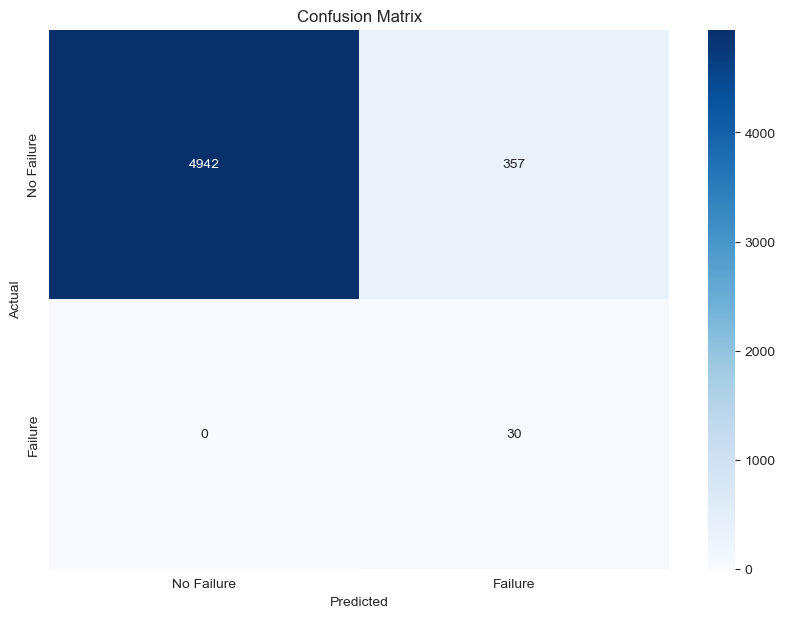

In [19]:


# Создание меток для выхода из строя
df['failure'] = df.groupby('id')['cycle'].transform(lambda x: x == x.max()).astype(int)

# Расширение окна отказов (10 циклов, включая сам отказ)
window_size = 10

def apply_rolling_window(group, window_size):
    group['failure_window'] = group['failure'].rolling(window=window_size, min_periods=1).max().shift(-(window_size-1)).fillna(0)
    return group

df = df.groupby('id').apply(apply_rolling_window, window_size=window_size).reset_index(drop=True)

# Фильтрация данных для первых 50 моторов
train_ids = df['id'].unique()[:50]
test_ids = df['id'].unique()[50:]

# Создание признаков на основе временного окна
time_steps = 30

def create_sequences(df, time_steps):
    X, y = [], []
    for i in range(len(df) - time_steps):
        X.append(df.iloc[i:(i + time_steps)].values)
        y.append(df.iloc[i + time_steps]['failure_window'])
    return np.array(X), np.array(y)

# Разделение данных на обучающие и тестовые наборы
train_data = df[df['id'].isin(train_ids)]
test_data = df[df['id'].isin(test_ids)]

X_train_list, y_train_list = [], []
X_test_list, y_test_list = [], []

# Создание последовательностей для каждого двигателя отдельно для обучения
for motor_id in train_ids:
    motor_data = train_data[train_data['id'] == motor_id].drop(columns=['id', 'cycle'])
    X_motor, y_motor = create_sequences(motor_data, time_steps)
    X_train_list.append(X_motor)
    y_train_list.append(y_motor)

X_train = np.concatenate(X_train_list)
y_train = np.concatenate(y_train_list)

# Создание последовательностей для каждого двигателя отдельно для тестирования
for motor_id in test_ids:
    motor_data = test_data[test_data['id'] == motor_id].drop(columns=['id', 'cycle'])
    X_motor, y_motor = create_sequences(motor_data, time_steps)
    X_test_list.append(X_motor)
    y_test_list.append(y_motor)

X_test = np.concatenate(X_test_list)
y_test = np.concatenate(y_test_list)

# Стандартизация данных
scaler = StandardScaler()
X_train = X_train.reshape(-1, X_train.shape[2])
X_test = X_test.reshape(-1, X_test.shape[2])

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = X_train.reshape(-1, time_steps, X_train.shape[1])
X_test = X_test.reshape(-1, time_steps, X_test.shape[1])

# Создание модели RNN
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(time_steps, X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Обучение модели с использованием взвешенных классов
class_weight = {0: 1., 1: 100.}  # Взвешенные классы

history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.2, class_weight=class_weight)

# Оценка модели
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)

accuracy = accuracy_score(y_test, y_pred_classes)
recall = recall_score(y_test, y_pred_classes, zero_division=0)
precision = precision_score(y_test, y_pred_classes, zero_division=0)
f1 = f1_score(y_test, y_pred_classes, zero_division=0)

print(f"Test Accuracy: {accuracy}")
print(f"Test Recall: {recall}")
print(f"Test Precision: {precision}")
print(f"Test F1 Score: {f1}")

# Построение матрицы ошибок
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Failure', 'Failure'], yticklabels=['No Failure', 'Failure'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


#### 3.2 Base model

Baseline Model Test Accuracy: 0.00562957402889848
Baseline Model Test Recall: 1.0
Baseline Model Test Precision: 0.00562957402889848
Baseline Model Test F1 Score: 0.011196118678857996


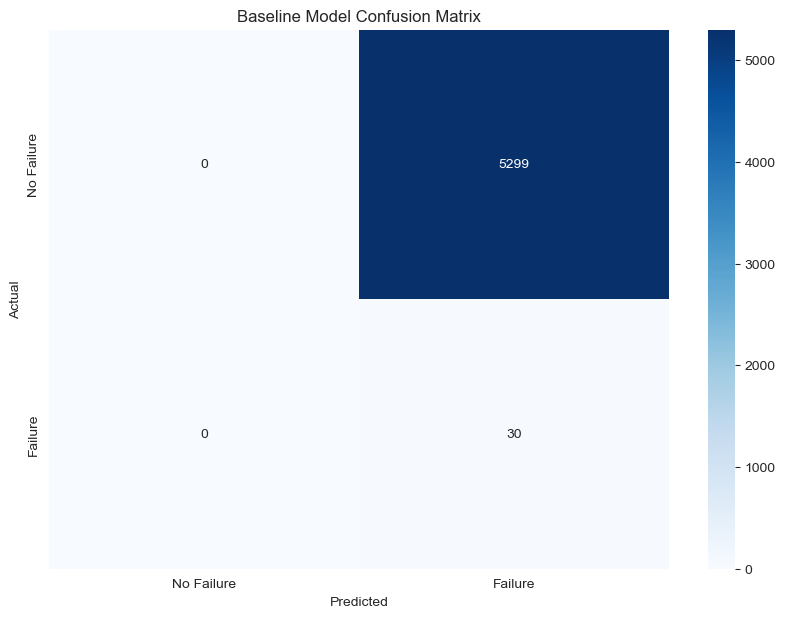

In [15]:
# Модель, которая всегда предсказывает поломку
y_pred_baseline = np.ones_like(y_test)

# Оценка базовой модели
accuracy_baseline = accuracy_score(y_test, y_pred_baseline)
recall_baseline = recall_score(y_test, y_pred_baseline, zero_division=0)
precision_baseline = precision_score(y_test, y_pred_baseline, zero_division=0)
f1_baseline = f1_score(y_test, y_pred_baseline, zero_division=0)

print(f"Baseline Model Test Accuracy: {accuracy_baseline}")
print(f"Baseline Model Test Recall: {recall_baseline}")
print(f"Baseline Model Test Precision: {precision_baseline}")
print(f"Baseline Model Test F1 Score: {f1_baseline}")

# Построение матрицы ошибок для базовой модели
cm_baseline = confusion_matrix(y_test, y_pred_baseline)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_baseline, annot=True, fmt='d', cmap='Blues', xticklabels=['No Failure', 'Failure'], yticklabels=['No Failure', 'Failure'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Baseline Model Confusion Matrix')
plt.show()

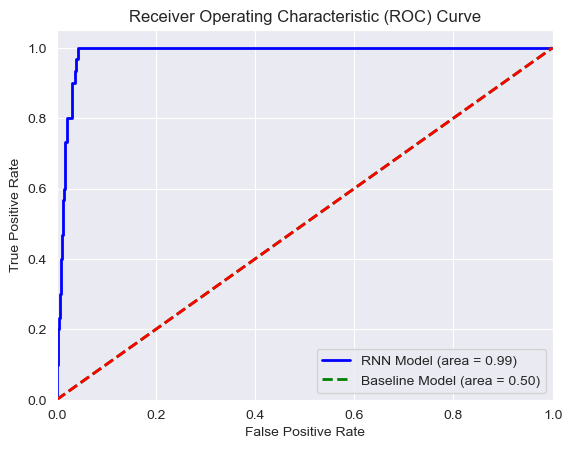

In [24]:
# Построение ROC-кривой и вычисление AUC для нашей модели
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

# Базовая модель: предсказывает всегда поломку (все единицы)
y_pred_baseline = np.ones_like(y_test)
fpr_baseline, tpr_baseline, _ = roc_curve(y_test, y_pred_baseline)
roc_auc_baseline = roc_auc_score(y_test, y_pred_baseline)

# Построение ROC-кривых для обеих моделей на одном графике
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'RNN Model (area = {roc_auc:.2f})')
plt.plot(fpr_baseline, tpr_baseline, color='green', lw=2, linestyle='--', label=f'Baseline Model (area = {roc_auc_baseline:.2f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

##### Сравнение моделей:
На графике ROC-AUC видно что базовая модель идет по диагонали, то есть не обладает предсказательной способностью. RNN модель хорошо стремится к 1.
Если посмотреть на Confusion Matrix, то мы видим что у нас все 30 аварийных точек предсказано, и самое главное ни одной не классифицированно ошибочно как НЕаварийная.
Мы можем обосновано говорить о применимости нашей модели при данных условиях задачи, но при этом однозначно сделать вывод о реальной применимости модели мы не можем, т.к. нужен контекст:
- сколько стоит каждая операция? Например False Positive ведет к излишнему дорогому ТО, сравнимому в какой-то степени с пропущенной поломкой. Иными словами, экономическая составляющая будет влять на метрики 
- каков характер циклов, это будет влиять как на временное окно модели, так и на "аварийное окно" которое мы задаем 

## 4.Выводы

Были загружены и проанализированы предоставленные данные, которые включают идентификаторы моторов, циклы работы, показания датчиков и настройки, изменяемые в конце каждого цикла. Мы удалили ненужные колонки, такие как константные величины и гиперпараметры системы, так как они не влияют на результат модели.

Мы провели визуализацию данных для случайного двигателя и построили матрицу корреляции, чтобы понять взаимосвязь между различными параметрами. Высокая корреляция между параметрами позволила нам сделать вывод, что для дальнейшей оптимизации модели можно использовать только часть признаков.

Для прогнозирования отказов моторов была выбрана рекуррентная нейронная сеть (RNN). Основные шаги включают:

Создание меток для выхода из строя и расширение окна отказов до 10 циклов.
Разделение данных на тренировочные (первые 50 моторов) и тестовые (все, что после 50) наборы.
Использование временного окна в 30 циклов для создания признаков.
Обучение модели с использованием взвешенных классов, чтобы компенсировать дисбаланс классов.
Модель была обучена и протестирована, и были получены следующие метрики:

Test Accuracy: 0.9330080690561081
Test Recall: 1.0
Test Precision: 0.07751937984496124
Test F1 Score: 0.14388489208633096

На основании этих метрик можно сделать вывод, что модель хорошо справляется с задачей нахождения всех аварийных точек (высокая полнота), но имеет низкую точность, что означает большое количество ложных срабатываний.

Что еще можно сделать:
- порегулировать гиперпараметры
- попробовать построить другие модели (Catboost, XGBoost)
- попробовать библиотеку для оверсэмплинга для временных рядов чтобы исправить дисбаланс классов (https://github.com/Hadlock-Lab/tSMOTE)
- вот здесь в статье упоминаются скрытые модели маркова для предсказания неисправностей (http://itas2015.iitp.ru/pdf/1570207677.pdf), возможно стоит реализовать